In [31]:
# LIBRARY
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score, roc_auc_score, multilabel_confusion_matrix, roc_curve
from scipy.sparse import issparse
import time

In [32]:
# DATA
df_brfss = pd.read_csv('/Users/macbook/Library/CloudStorage/GoogleDrive-nurrachmandzakiyullah@gmail.com/My Drive/23. Colab Notebooks/1. AI_Project/2. PhD_Dzaki_BRFSS/Fix_Model_HP/3. Fix Model/Final_dataset_Diabetes_Complication.csv')
x = df_brfss.iloc[:, :26].values
X = preprocessing.normalize(x)
y = df_brfss.iloc[:, 26:].values-1

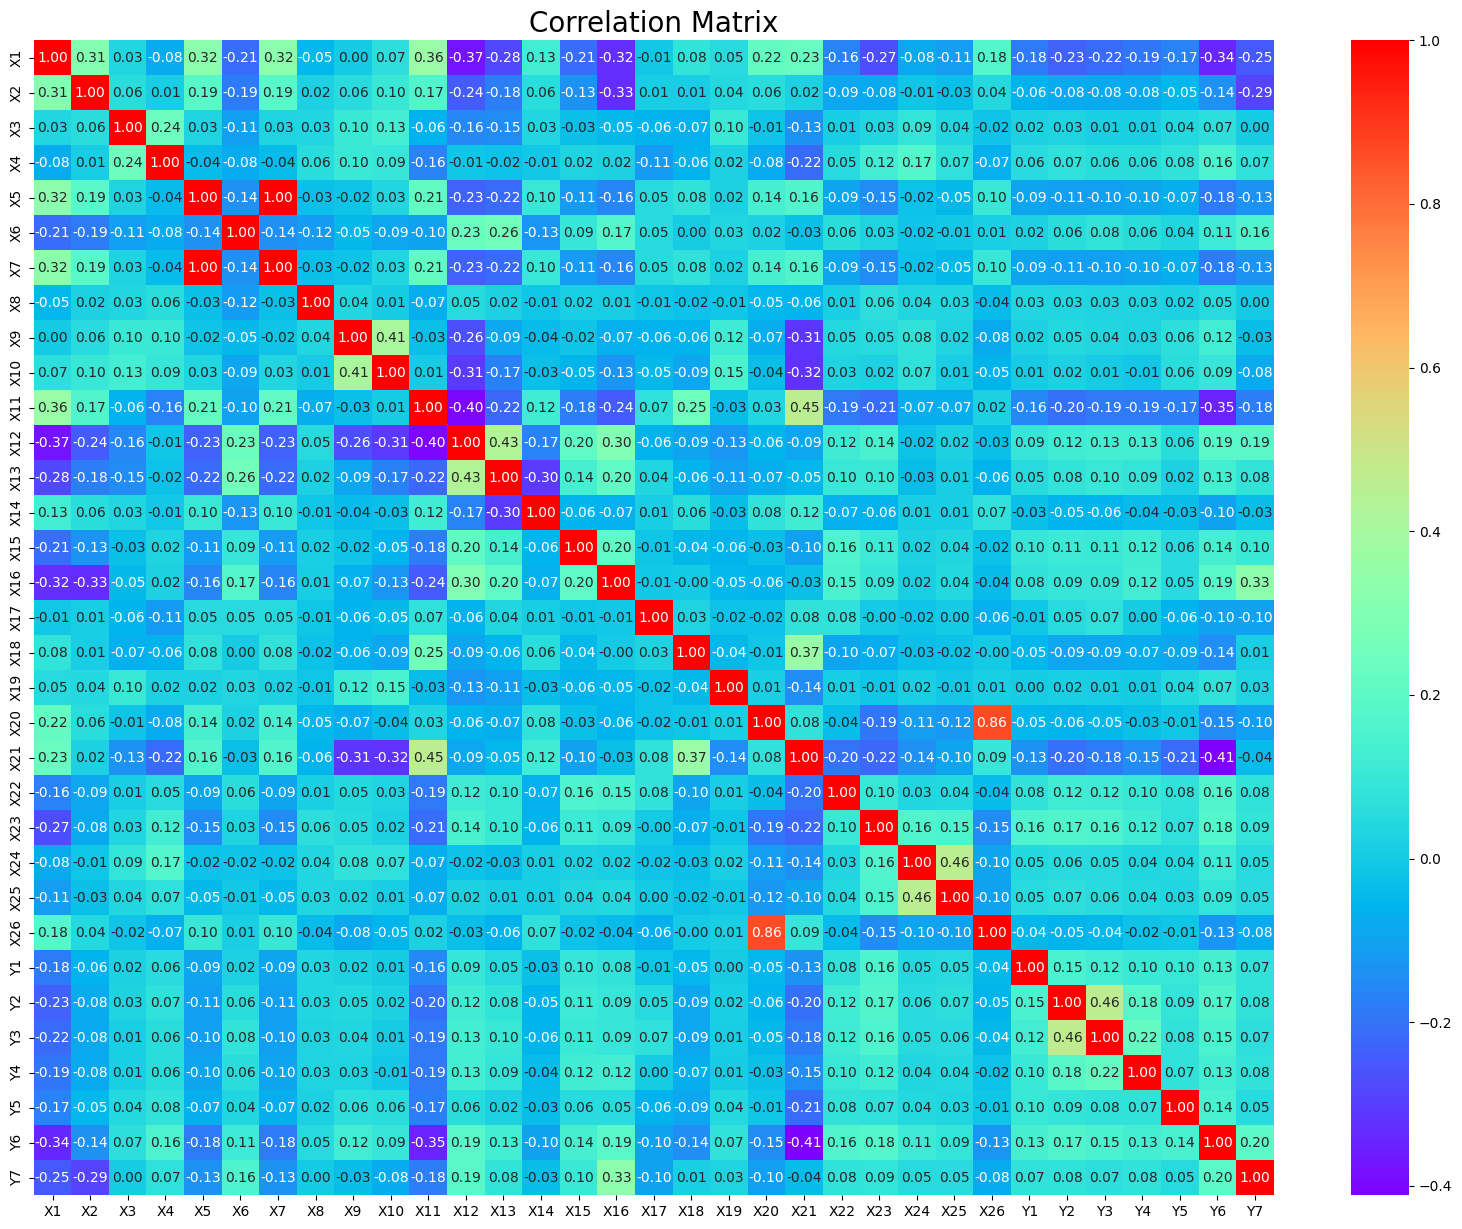

In [33]:
# Correlation matrix graph of the data set
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(df_brfss.corr(), annot=True, fmt=".2f", ax=ax, cmap = "rainbow" )
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [34]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
import copy
import numpy as np

class ClassifierChain:
   
    def __init__(self, classifier):
        self.classifier = classifier

    def fit(self, X, y, order=None):
        """Fit classifier with training data

        Parameters
        ----------
        order: list
               The order of the labels to join training
        """
        self.m = X.shape[0]
        self.label_count = y.shape[1]
        if order is None:
            self.order = list(range(y.shape[1]))
        elif sorted(order) != list(range(y.shape[1])):
            raise ValueError('invalid order of labels')
        else:
            self.order = order
        self.classifiers = []
        X_extended = copy.deepcopy(X)
        for i in range(self.label_count):
            classifier = copy.deepcopy(self.classifier)
            y_subset = y[:, self.order[i]]
            classifier.fit(X_extended, y_subset)
            self.classifiers.append(classifier)
            X_extended = np.hstack([X_extended, np.vstack(y_subset)])
        return self

    def predict(self, X_pre):
        res = np.zeros((X_pre.shape[0], self.label_count))
        for i in range(self.label_count):
            y_subset = self.classifiers[i].predict(X_pre)
            X_pre = np.hstack([X_pre, np.vstack(y_subset)])
            res[:, self.order[i]] = y_subset
        return res


In [36]:
# Decisions Tree Model
# PROBLEM TRANSFORMATION
base_classifier = DecisionTreeClassifier()
model = ClassifierChain(classifier=base_classifier)

In [37]:
# Get the parameter values
params = base_classifier.get_params()

# Print the parameter values
print(params)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [38]:
# Train with time
start = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start
print(training_time)

111.41046810150146


In [39]:
# Testing with time
start = time.time()
# make a prediction on the test set
yhat = model.predict(X_test)
testing_time = time.time() - start
print(testing_time)

yprob=yhat #UNTUK ROC AUC KRITING
# round probabilities to class labels
yhat = yhat.round() #UNTUK EVAL METRIK
print(yprob[1,])
print(yhat[1,])


1.6726298332214355
[1. 0. 0. 1. 1. 0. 1.]
[1. 0. 0. 1. 1. 0. 1.]


# 1. Matrix Evaluation Label Based


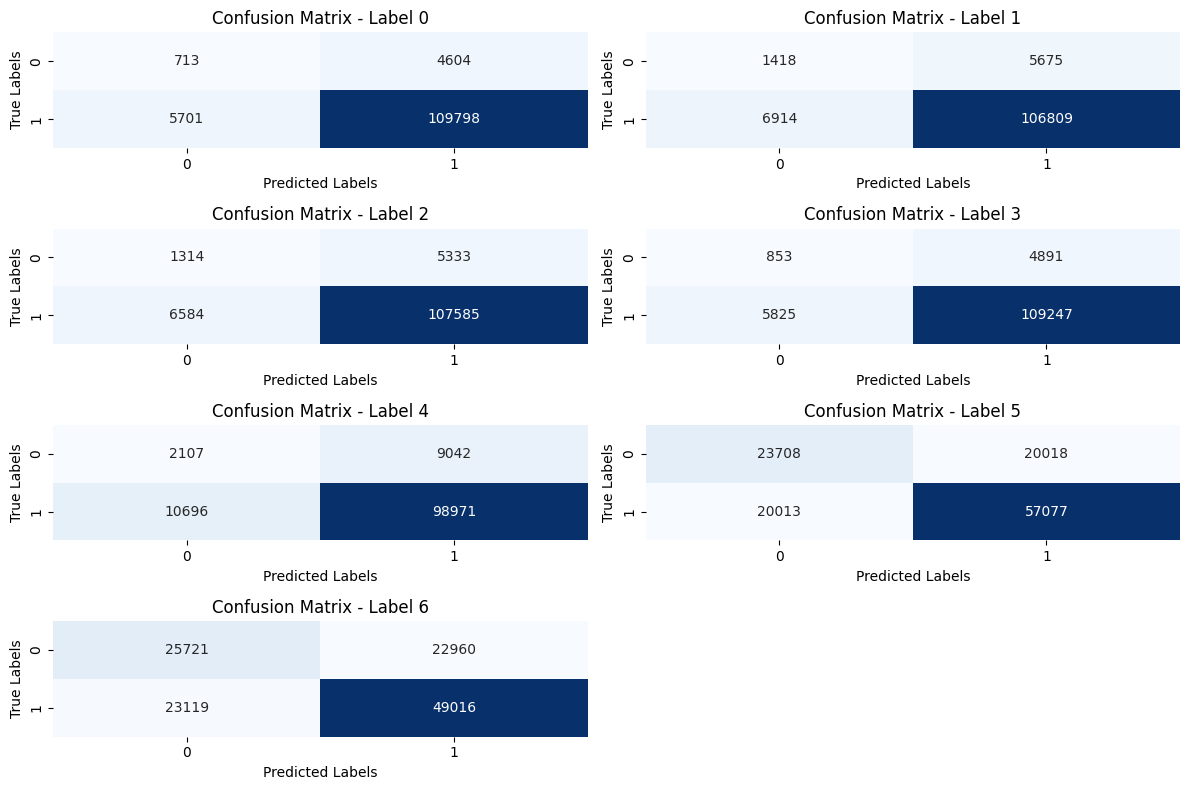

In [40]:
#hitung CM untuk eval metrik yang lain pre memori

# Multilabel confusion matrix
cm = multilabel_confusion_matrix(y_test, yhat)

# Determine the grid dimensions for subplots
num_labels = cm.shape[0]
cols = min(num_labels, 2)
rows = (num_labels + cols - 1) // cols

# Plot confusion matrix
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
for i, (matrix, ax) in enumerate(zip(cm, axes.ravel())):
    sns.heatmap(matrix, annot=True, fmt="d", cbar=False, cmap='Blues', ax=ax)
    ax.set_title(f"Confusion Matrix - Label {i}")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

# Remove unused subplots if necessary
if num_labels < rows * cols:
    for j in range(num_labels, rows * cols):
        fig.delaxes(axes.ravel()[j])

plt.tight_layout()
plt.show()

In [41]:
# membuat AUC ROC label A
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_test[:,1], yprob[:,1])
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.5695592805380015


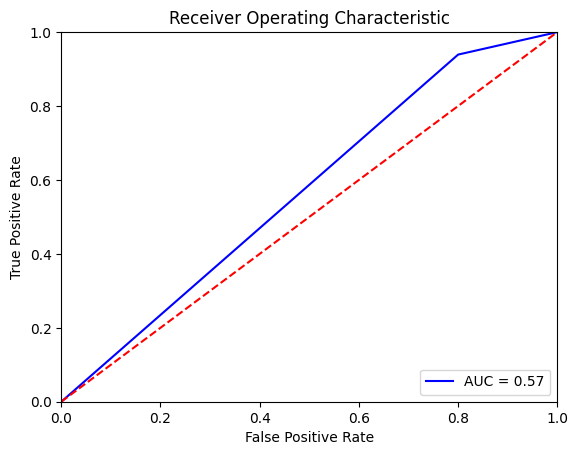

In [42]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

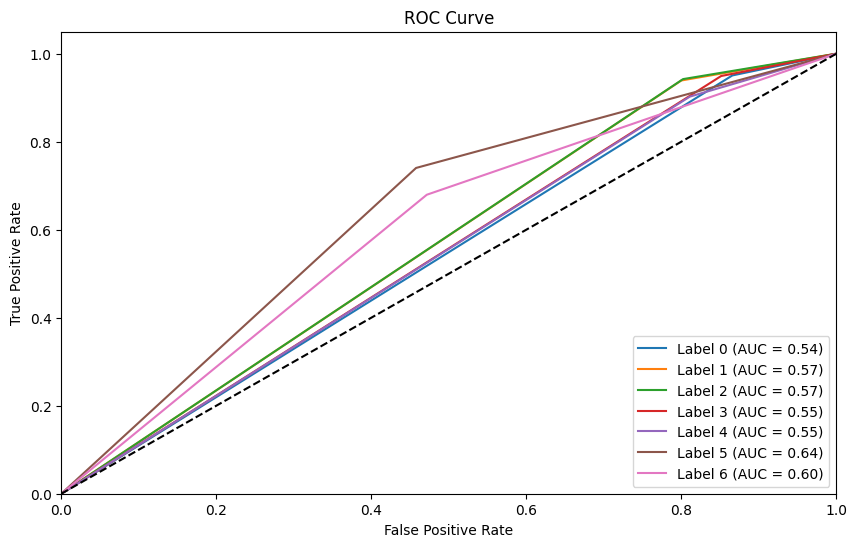

In [43]:
plt.figure(figsize=(10, 6))
roc_auc_per_label = dict()
#predictions=preds
for i in range(y.shape[1]):
    fpr, tpr, _ = metrics.roc_curve(y_test[:,i], yprob[:,i])
    roc_auc_per_label[i] = metrics.roc_auc_score(y_test[:,i], yprob[:,i])
    plt.plot(fpr, tpr, label='Label %d (AUC = %0.2f)' % (i, roc_auc_per_label[i]))
# Plot ROC curve for each label
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 2. Matrix Evaluation Example Based


In [44]:
# Evaluation metrics
accuracy = accuracy_score(y_test, yhat)
precision = precision_score(y_test, yhat, average='micro')
recall = recall_score(y_test, yhat, average='micro')
f1 = f1_score(y_test, yhat, average='micro')
hamming_loss_score = hamming_loss(y_test, yhat)
jaccard = jaccard_score(y_test, yhat, average='micro')
auc_roc = roc_auc_score(y_test, yhat)

In [45]:
# Print results
print('Training Time:', round(training_time, 2), 'seconds')
print('Testing Time on Specific Test Set:', round(testing_time, 2), 'seconds')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Hamming Loss:', hamming_loss_score)
print('Jaccard Score:', jaccard)
print('AUC-ROC:', auc_roc)

Training Time: 111.41 seconds
Testing Time on Specific Test Set: 1.67 seconds
Accuracy: 0.3055969408025427
Precision: 0.8980023234030823
Recall: 0.8900795282670365
F1 Score: 0.894023373315663
Hamming Loss: 0.17899119321944112
Jaccard Score: 0.8083564803678542
AUC-ROC: 0.5745470166035594


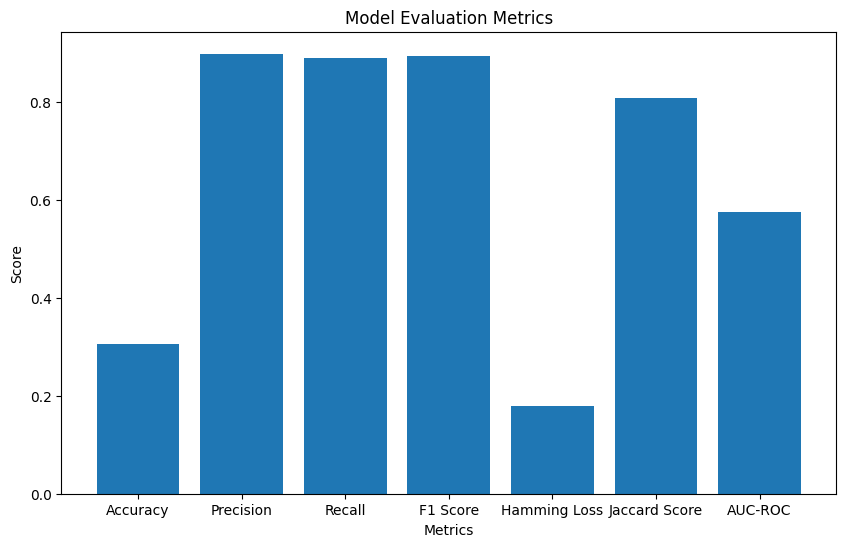

In [46]:

# Evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Hamming Loss', 'Jaccard Score', 'AUC-ROC']
values = [accuracy, precision, recall, f1, hamming_loss_score, jaccard, auc_roc]

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics, values)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.show()

In [47]:
import sklearn.metrics

print('Exact Match Ratio: {0}'.format(sklearn.metrics.accuracy_score(y_test, yhat, normalize=True, sample_weight=None)))
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_test, yhat))) 
print('Recall: {0}'.format(sklearn.metrics.precision_score(y_true=y_test, y_pred=yhat, average='samples'))) 
print('Precision: {0}'.format(sklearn.metrics.recall_score(y_true=y_test, y_pred=yhat, average='samples')))
print('F1 Measure: {0}'.format(sklearn.metrics.f1_score(y_true=y_test, y_pred=yhat, average='samples'))) 

Exact Match Ratio: 0.3055969408025427
Hamming loss: 0.17899119321944112


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.8923630424226371
Precision: 0.8842152923611504
F1 Measure: 0.8763397915799087


In [48]:
#Subet Accuracy atau Exact Match Ratio
from sklearn.metrics import accuracy_score
accuracy_score(y_test, yhat)

0.3055969408025427

In [49]:
# HITUNG HAMMING LOSS
from sklearn.metrics import hamming_loss
hamming_loss(y_test, yhat)

0.17899119321944112

In [50]:
from sklearn.metrics import jaccard_score
print('jaccard_score_Samples: {0}'.format(jaccard_score(y_test, yhat, average='samples')))
print('jaccard_score_Micro: {0}'.format(jaccard_score(y_test, yhat, average="micro")))
print('jaccard_score_Macro: {0}'.format(jaccard_score(y_test, yhat, average="macro")))


jaccard_score_Samples: 0.8036330925894394
jaccard_score_Micro: 0.8083564803678542
jaccard_score_Macro: 0.793807173133371


In [51]:
from sklearn.metrics import zero_one_loss
print('Zero_one_loss: {0}'.format(zero_one_loss(y_test, yhat)))
print('Zero_one_loss_Samples: {0}'.format(zero_one_loss(y_test, yhat, normalize=False)))

Zero_one_loss: 0.6944030591974573
Zero_one_loss_Samples: 83895


In [52]:
from sklearn.metrics import f1_score

print('f1_score_micro: {0}'.format(f1_score(y_test, yhat, average='micro')))
print('f1_score_macro: {0}'.format(f1_score(y_test, yhat, average='macro')))
print('f1_score_weighted: {0}'.format(f1_score(y_test, yhat, average='weighted')))
print('f1_score_none: {0}'.format(f1_score(y_test, yhat, average=None)))


f1_score_micro: 0.894023373315663
f1_score_macro: 0.8757490837882839
f1_score_weighted: 0.8941932809415117
f1_score_none: [0.95517636 0.94434743 0.94752232 0.95324811 0.90932562 0.74037033
 0.68025342]


In [53]:
from sklearn.metrics import fbeta_score

print('fbeta_macro: {0}'.format(fbeta_score(y_test, yhat, average='macro', beta=0.5)))
print('fbeta_micro: {0}'.format(fbeta_score(y_test, yhat, average='micro', beta=0.5)))
print('fbeta_weighted: {0}'.format(fbeta_score(y_test, yhat, average='weighted', beta=0.5)))
print('fbeta_none: {0}'.format(fbeta_score(y_test, yhat, average=None, beta=0.5)))

fbeta_macro: 0.8780255985060638
fbeta_micro: 0.8964065008189058
fbeta_weighted: 0.8966837691919572
fbeta_none: [0.95791885 0.94746114 0.95066459 0.95558444 0.9134902  0.74035593
 0.68070403]


In [54]:
from sklearn.metrics import precision_recall_fscore_support

print('recision_recall_fscore_support_macro: {0}'.format(precision_recall_fscore_support(y_test, yhat, average='macro')))
print('recision_recall_fscore_support_micro: {0}'.format(precision_recall_fscore_support(y_test, yhat, average='micro')))
print('recision_recall_fscore_support_weighted: {0}'.format(precision_recall_fscore_support(y_test, yhat, average='weighted')))
print('recision_recall_fscore_support_none: {0}'.format(precision_recall_fscore_support(y_test, yhat, average=None)))

recision_recall_fscore_support_macro: (0.8795518128227962, 0.8719886393578813, 0.8757490837882839, None)
recision_recall_fscore_support_micro: (0.8980023234030823, 0.8900795282670365, 0.894023373315663, None)
recision_recall_fscore_support_weighted: (0.8983534707328898, 0.8900795282670365, 0.8941932809415117, None)
recision_recall_fscore_support_none: (array([0.95975595, 0.94954838, 0.95277104, 0.95714836, 0.91628785,
       0.74034633, 0.68100478]), array([0.95064027, 0.93920315, 0.94233111, 0.94937952, 0.90246838,
       0.74039434, 0.67950371]), array([0.95517636, 0.94434743, 0.94752232, 0.95324811, 0.90932562,
       0.74037033, 0.68025342]), array([115499, 113723, 114169, 115072, 109667,  77090,  72135]))


In [55]:
from sklearn.metrics import precision_score
print('precision_score_macro: {0}'.format(precision_score(y_test, yhat, average='macro')))
print('precision_score_micro: {0}'.format(precision_score(y_test, yhat, average='micro')))
print('precision_score_weighted: {0}'.format(precision_score(y_test, yhat, average='weighted')))
print('precision_score_none: {0}'.format(precision_score(y_test, yhat, average=None)))
print('precision_score_zero_divisio: {0}'.format(precision_score(y_test, yhat, average=None, zero_division=1)))


precision_score_macro: 0.8795518128227962
precision_score_micro: 0.8980023234030823
precision_score_weighted: 0.8983534707328898
precision_score_none: [0.95975595 0.94954838 0.95277104 0.95714836 0.91628785 0.74034633
 0.68100478]
precision_score_zero_divisio: [0.95975595 0.94954838 0.95277104 0.95714836 0.91628785 0.74034633
 0.68100478]


In [56]:
from sklearn.metrics import recall_score
print('recall_score_macro: {0}'.format(recall_score(y_test, yhat, average='macro')))
print('recall_score_micro: {0}'.format(recall_score(y_test, yhat, average='micro')))
print('recall_score_weighted: {0}'.format(recall_score(y_test, yhat, average='weighted')))
print('recall_score_none: {0}'.format(recall_score(y_test, yhat, average=None)))
print('recall_score_zero_divisio: {0}'.format(recall_score(y_test, yhat, average=None, zero_division=1)))


recall_score_macro: 0.8719886393578813
recall_score_micro: 0.8900795282670365
recall_score_weighted: 0.8900795282670365
recall_score_none: [0.95064027 0.93920315 0.94233111 0.94937952 0.90246838 0.74039434
 0.67950371]
recall_score_zero_divisio: [0.95064027 0.93920315 0.94233111 0.94937952 0.90246838 0.74039434
 0.67950371]


In [57]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, yhat)

array([[[   713,   4604],
        [  5701, 109798]],

       [[  1418,   5675],
        [  6914, 106809]],

       [[  1314,   5333],
        [  6584, 107585]],

       [[   853,   4891],
        [  5825, 109247]],

       [[  2107,   9042],
        [ 10696,  98971]],

       [[ 23708,  20018],
        [ 20013,  57077]],

       [[ 25721,  22960],
        [ 23119,  49016]]])

In [58]:
# CLASSIFICATION REPORT : precision, recacll f1-score support every label
from sklearn.metrics import classification_report 
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96    115499
           1       0.95      0.94      0.94    113723
           2       0.95      0.94      0.95    114169
           3       0.96      0.95      0.95    115072
           4       0.92      0.90      0.91    109667
           5       0.74      0.74      0.74     77090
           6       0.68      0.68      0.68     72135

   micro avg       0.90      0.89      0.89    717355
   macro avg       0.88      0.87      0.88    717355
weighted avg       0.90      0.89      0.89    717355
 samples avg       0.89      0.88      0.88    717355



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
print("Actual \n", y_test)
print("\nPredicted \n", yhat)

Actual 
 [[1 1 1 ... 1 0 0]
 [0 1 1 ... 1 0 0]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 0 1]]

Predicted 
 [[1. 1. 1. ... 1. 0. 1.]
 [1. 0. 0. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]]
